In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import dask
import dask.dataframe as dd
from dask.distributed import Client, progress
#import dask.array as dask
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler
%matplotlib inline
import doctest
#%matplotlib widget


In [2]:
#close existing dask connection 
def closeExistingDaskConnection():   
    """Closes an existing Dask connection for you, so you don't have resource leaks

    If called with an existing connection, from prior Jupyter runs, it will close it.
    >>> closeExistingDaskConnection()
    
    """
    
    #temp variable for client
    closed = None
    
    try:
        #if the client exists from prior runs
        if client is not None:
            #close it
            client.close()
            
            #print("closed existing connection, ",client)
            #set closed = client to get state
            closed = client
    #if the client variable did not exist (first run) then a name exception is thrown which we can catch
    except Exception as e:
        if str(e)!= "name 'client' is not defined":
            raise(e)
        #print(e)
    
    return closed

#call because we need to close existing connections
client = closeExistingDaskConnection()
if __name__ == "__main__":
    doctest.testmod(verbose=1)

Trying:
    closeExistingDaskConnection()
Expecting nothing
ok
1 items had no tests:
    __main__
1 items passed all tests:
   1 tests in __main__.closeExistingDaskConnection
1 tests in 2 items.
1 passed and 0 failed.
Test passed.


In [3]:
display(client)

None

In [5]:
#get new connection
#client = Client(n_workers=2, threads_per_worker=2, memory_limit='8GB')
#watch out the dns can change as well on reboots!
client = Client(address="ec2-44-203-205-137.compute-1.amazonaws.com:8786",timeout="60000000s",)
display(client)

<Client: 'tcp://172.31.9.62:8786' processes=1 threads=2, memory=15.71 GiB>

In [6]:
#set timeouts
#distributed.comm.timeouts.connect
dask.config.set({'distributed.comm.timeouts.connect': "6000s"})
print("connect timeout",dask.config.get('distributed.comm.timeouts.connect'))

dask.config.set({'distributed.comm.timeouts.tcp': "6000s"})
print("connect timeout",dask.config.get('distributed.comm.timeouts.tcp'))


connect timeout 6000s
connect timeout 6000s


CPU times: total: 1.56 s
Wall time: 1min 33s


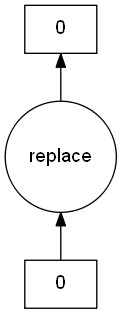

In [7]:
%%time
#live 
live = True
icu = None

if live == True:
    #icu = pd.read_csv("https://healthdata.gov/api/views/anag-cw7u/rows.csv?accessType=DOWNLOAD")
    icu = dd.read_csv("https://healthdata.gov/api/views/anag-cw7u/rows.csv?accessType=DOWNLOAD",blocksize=None,dtype=object)
    icu = icu.persist()
    
    
else:
    print("using local copy")
    icu = dd.read_csv("data/COVID-19_Reported_Patient_Impact_and_Hospital_Capacity_by_Facility.csv",dtype=object)
#local
#icu = pd.read_csv("data/icu.csv")
icu = icu.replace(-999999,0)
icu.head()
icu.visualize()

In [8]:
%%time
icu.head()

CPU times: total: 46.9 ms
Wall time: 1.34 s


,hospital_pk,collection_week,state,ccn,hospital_name,address,city,zip,hospital_subtype,fips_code,is_metro_micro,total_beds_7_day_avg,all_adult_hospital_beds_7_day_avg,all_adult_hospital_inpatient_beds_7_day_avg,inpatient_beds_used_7_day_avg,all_adult_hospital_inpatient_bed_occupied_7_day_avg,inpatient_beds_used_covid_7_day_avg,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg,total_adult_patients_hospitalized_confirmed_covid_7_day_avg,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg,total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg,inpatient_beds_7_day_avg,total_icu_beds_7_day_avg,total_staffed_adult_icu_beds_7_day_avg,icu_beds_used_7_day_avg,staffed_adult_icu_bed_occupancy_7_day_avg,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg,staffed_icu_adult_patients_confirmed_covid_7_day_avg,total_patients_hospitalized_confirmed_influenza_7_day_avg,icu_patients_confirmed_influenza_7_day_avg,total_patients_hospitalized_confirmed_influenza_and_covid_7_day_avg,total_beds_7_day_sum,all_adult_hospital_beds_7_day_sum,all_adult_hospital_inpatient_beds_7_day_sum,inpatient_beds_used_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_sum,inpatient_beds_used_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_covid_7_day_sum,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,total_pediatric_patients_hospitalized_confirmed_covid_7_day_sum,inpatient_beds_7_day_sum,total_icu_beds_7_day_sum,total_staffed_adult_icu_beds_7_day_sum,icu_beds_used_7_day_sum,staffed_adult_icu_bed_occupancy_7_day_sum,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum,staffed_icu_adult_patients_confirmed_covid_7_day_sum,total_patients_hospitalized_confirmed_influenza_7_day_sum,icu_patients_confirmed_influenza_7_day_sum,total_patients_hospitalized_confirmed_influenza_and_covid_7_day_sum,total_beds_7_day_coverage,all_adult_hospital_beds_7_day_coverage,all_adult_hospital_inpatient_beds_7_day_coverage,inpatient_beds_used_7_day_coverage,all_adult_hospital_inpatient_bed_occupied_7_day_coverage,inpatient_beds_used_covid_7_day_coverage,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_coverage,total_adult_patients_hospitalized_confirmed_covid_7_day_coverage,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_coverage,total_pediatric_patients_hospitalized_confirmed_covid_7_day_coverage,inpatient_beds_7_day_coverage,total_icu_beds_7_day_coverage,total_staffed_adult_icu_beds_7_day_coverage,icu_beds_used_7_day_coverage,staffed_adult_icu_bed_occupancy_7_day_coverage,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_coverage,staffed_icu_adult_patients_confirmed_covid_7_day_coverage,total_patients_hospitalized_confirmed_influenza_7_day_coverage,icu_patients_confirmed_influenza_7_day_coverage,total_patients_hospitalized_confirmed_influenza_and_covid_7_day_coverage,previous_day_admission_adult_covid_confirmed_7_day_sum,previous_day_admission_adult_covid_confirmed_18-19_7_day_sum,previous_day_admission_adult_covid_confirmed_20-29_7_day_sum,previous_day_admission_adult_covid_confirmed_30-39_7_day_sum,previous_day_admission_adult_covid_confirmed_40-49_7_day_sum,previous_day_admission_adult_covid_confirmed_50-59_7_day_sum,previous_day_admission_adult_covid_confirmed_60-69_7_day_sum,previous_day_admission_adult_covid_confirmed_70-79_7_day_sum,previous_day_admission_adult_covid_confirmed_80+_7_day_sum,previous_day_admission_adult_covid_confirmed_unknown_7_day_sum,previous_day_admission_pediatric_covid_confirmed_7_day_sum,previous_day_covid_ED_visits_7_day_sum,previous_day_admission_adult_covid_suspected_7_day_sum,previous_day_admission_adult_covid_suspected_18-19_7_day_sum,previous_day_admission_adult_covid_suspected_20-29_7_day_sum,previous_day_admission_adult_covid_suspected_30-39_7_day_sum,previous_day_admission_adult_covid_su

In [8]:
icu.collection_week = dd.to_datetime(icu.collection_week,unit='ns')
print(icu.dtypes)
icu.head()

hospital_pk                                                                                   object
collection_week                                                                       datetime64[ns]
state                                                                                         object
ccn                                                                                           object
hospital_name                                                                                 object
address                                                                                       object
city                                                                                          object
zip                                                                                           object
hospital_subtype                                                                              object
fips_code                                                                                  

,hospital_pk,collection_week,state,ccn,hospital_name,address,city,zip,hospital_subtype,fips_code,is_metro_micro,total_beds_7_day_avg,all_adult_hospital_beds_7_day_avg,all_adult_hospital_inpatient_beds_7_day_avg,inpatient_beds_used_7_day_avg,all_adult_hospital_inpatient_bed_occupied_7_day_avg,inpatient_beds_used_covid_7_day_avg,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg,total_adult_patients_hospitalized_confirmed_covid_7_day_avg,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg,total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg,inpatient_beds_7_day_avg,total_icu_beds_7_day_avg,total_staffed_adult_icu_beds_7_day_avg,icu_beds_used_7_day_avg,staffed_adult_icu_bed_occupancy_7_day_avg,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg,staffed_icu_adult_patients_confirmed_covid_7_day_avg,total_patients_hospitalized_confirmed_influenza_7_day_avg,icu_patients_confirmed_influenza_7_day_avg,total_patients_hospitalized_confirmed_influenza_and_covid_7_day_avg,total_beds_7_day_sum,all_adult_hospital_beds_7_day_sum,all_adult_hospital_inpatient_beds_7_day_sum,inpatient_beds_used_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_sum,inpatient_beds_used_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_covid_7_day_sum,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,total_pediatric_patients_hospitalized_confirmed_covid_7_day_sum,inpatient_beds_7_day_sum,total_icu_beds_7_day_sum,total_staffed_adult_icu_beds_7_day_sum,icu_beds_used_7_day_sum,staffed_adult_icu_bed_occupancy_7_day_sum,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum,staffed_icu_adult_patients_confirmed_covid_7_day_sum,total_patients_hospitalized_confirmed_influenza_7_day_sum,icu_patients_confirmed_influenza_7_day_sum,total_patients_hospitalized_confirmed_influenza_and_covid_7_day_sum,total_beds_7_day_coverage,all_adult_hospital_beds_7_day_coverage,all_adult_hospital_inpatient_beds_7_day_coverage,inpatient_beds_used_7_day_coverage,all_adult_hospital_inpatient_bed_occupied_7_day_coverage,inpatient_beds_used_covid_7_day_coverage,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_coverage,total_adult_patients_hospitalized_confirmed_covid_7_day_coverage,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_coverage,total_pediatric_patients_hospitalized_confirmed_covid_7_day_coverage,inpatient_beds_7_day_coverage,total_icu_beds_7_day_coverage,total_staffed_adult_icu_beds_7_day_coverage,icu_beds_used_7_day_coverage,staffed_adult_icu_bed_occupancy_7_day_coverage,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_coverage,staffed_icu_adult_patients_confirmed_covid_7_day_coverage,total_patients_hospitalized_confirmed_influenza_7_day_coverage,icu_patients_confirmed_influenza_7_day_coverage,total_patients_hospitalized_confirmed_influenza_and_covid_7_day_coverage,previous_day_admission_adult_covid_confirmed_7_day_sum,previous_day_admission_adult_covid_confirmed_18-19_7_day_sum,previous_day_admission_adult_covid_confirmed_20-29_7_day_sum,previous_day_admission_adult_covid_confirmed_30-39_7_day_sum,previous_day_admission_adult_covid_confirmed_40-49_7_day_sum,previous_day_admission_adult_covid_confirmed_50-59_7_day_sum,previous_day_admission_adult_covid_confirmed_60-69_7_day_sum,previous_day_admission_adult_covid_confirmed_70-79_7_day_sum,previous_day_admission_adult_covid_confirmed_80+_7_day_sum,previous_day_admission_adult_covid_confirmed_unknown_7_day_sum,previous_day_admission_pediatric_covid_confirmed_7_day_sum,previous_day_covid_ED_visits_7_day_sum,previous_day_admission_adult_covid_suspected_7_day_sum,previous_day_admission_adult_covid_suspected_18-19_7_day_sum,previous_day_admission_adult_covid_suspected_20-29_7_day_sum,previous_day_admission_adult_covid_suspected_30-39_7_day_sum,previous_day_admission_adult_covid_su

In [9]:
#sort to find latest collection week
icu = icu.sort_values(by=["collection_week"],ascending=False)
#icu.persist()
icu.head(10)

,hospital_pk,collection_week,state,ccn,hospital_name,address,city,zip,hospital_subtype,fips_code,is_metro_micro,total_beds_7_day_avg,all_adult_hospital_beds_7_day_avg,all_adult_hospital_inpatient_beds_7_day_avg,inpatient_beds_used_7_day_avg,all_adult_hospital_inpatient_bed_occupied_7_day_avg,inpatient_beds_used_covid_7_day_avg,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg,total_adult_patients_hospitalized_confirmed_covid_7_day_avg,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg,total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg,inpatient_beds_7_day_avg,total_icu_beds_7_day_avg,total_staffed_adult_icu_beds_7_day_avg,icu_beds_used_7_day_avg,staffed_adult_icu_bed_occupancy_7_day_avg,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg,staffed_icu_adult_patients_confirmed_covid_7_day_avg,total_patients_hospitalized_confirmed_influenza_7_day_avg,icu_patients_confirmed_influenza_7_day_avg,total_patients_hospitalized_confirmed_influenza_and_covid_7_day_avg,total_beds_7_day_sum,all_adult_hospital_beds_7_day_sum,all_adult_hospital_inpatient_beds_7_day_sum,inpatient_beds_used_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_sum,inpatient_beds_used_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_covid_7_day_sum,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,total_pediatric_patients_hospitalized_confirmed_covid_7_day_sum,inpatient_beds_7_day_sum,total_icu_beds_7_day_sum,total_staffed_adult_icu_beds_7_day_sum,icu_beds_used_7_day_sum,staffed_adult_icu_bed_occupancy_7_day_sum,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum,staffed_icu_adult_patients_confirmed_covid_7_day_sum,total_patients_hospitalized_confirmed_influenza_7_day_sum,icu_patients_confirmed_influenza_7_day_sum,total_patients_hospitalized_confirmed_influenza_and_covid_7_day_sum,total_beds_7_day_coverage,all_adult_hospital_beds_7_day_coverage,all_adult_hospital_inpatient_beds_7_day_coverage,inpatient_beds_used_7_day_coverage,all_adult_hospital_inpatient_bed_occupied_7_day_coverage,inpatient_beds_used_covid_7_day_coverage,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_coverage,total_adult_patients_hospitalized_confirmed_covid_7_day_coverage,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_coverage,total_pediatric_patients_hospitalized_confirmed_covid_7_day_coverage,inpatient_beds_7_day_coverage,total_icu_beds_7_day_coverage,total_staffed_adult_icu_beds_7_day_coverage,icu_beds_used_7_day_coverage,staffed_adult_icu_bed_occupancy_7_day_coverage,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_coverage,staffed_icu_adult_patients_confirmed_covid_7_day_coverage,total_patients_hospitalized_confirmed_influenza_7_day_coverage,icu_patients_confirmed_influenza_7_day_coverage,total_patients_hospitalized_confirmed_influenza_and_covid_7_day_coverage,previous_day_admission_adult_covid_confirmed_7_day_sum,previous_day_admission_adult_covid_confirmed_18-19_7_day_sum,previous_day_admission_adult_covid_confirmed_20-29_7_day_sum,previous_day_admission_adult_covid_confirmed_30-39_7_day_sum,previous_day_admission_adult_covid_confirmed_40-49_7_day_sum,previous_day_admission_adult_covid_confirmed_50-59_7_day_sum,previous_day_admission_adult_covid_confirmed_60-69_7_day_sum,previous_day_admission_adult_covid_confirmed_70-79_7_day_sum,previous_day_admission_adult_covid_confirmed_80+_7_day_sum,previous_day_admission_adult_covid_confirmed_unknown_7_day_sum,previous_day_admission_pediatric_covid_confirmed_7_day_sum,previous_day_covid_ED_visits_7_day_sum,previous_day_admission_adult_covid_suspected_7_day_sum,previous_day_admission_adult_covid_suspected_18-19_7_day_sum,previous_day_admission_adult_covid_suspected_20-29_7_day_sum,previous_day_admission_adult_covid_suspected_30-39_7_day_sum,previous_day_admission_adult_covid_su

In [10]:
type(icu)

dask.dataframe.core.DataFrame

In [11]:
type(icu.tail(10))

pandas.core.frame.DataFrame

In [12]:
icu.collection_week

Dask Series Structure:
npartitions=1
    datetime64[ns]
               ...
Name: collection_week, dtype: datetime64[ns]
Dask Name: getitem, 7 tasks

In [13]:
#get last collection week
week = icu.collection_week.compute()
#week = week['collection_week'].iloc[0]
week = week.to_numpy()[0]

In [14]:
week = str(week.astype('datetime64[D]'))
week

'2022-03-18'

In [15]:
#week = str(week.year)+"-"+str(week.month)+"-"+str(week.day)
#week

In [16]:
icu = icu.query(f"collection_week >= '{week}'")

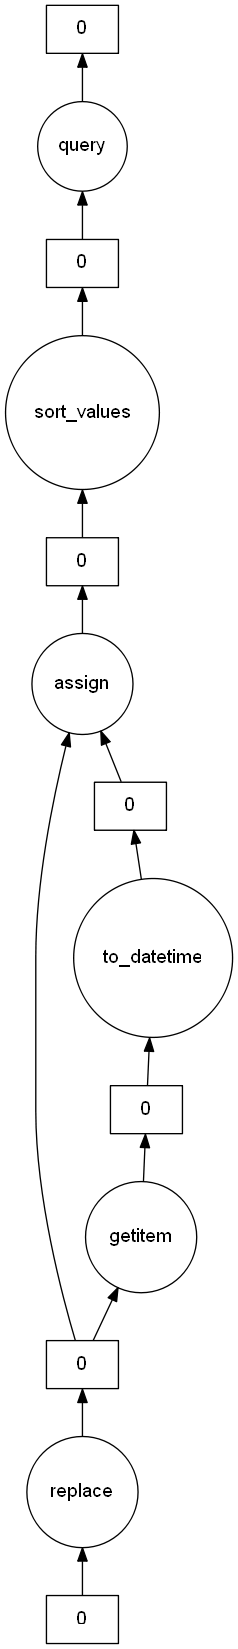

In [17]:
type(icu)
icu.visualize()

In [18]:
#icu = icu.query("collection_week >='2022/02/05'")
icu.head(50)

,hospital_pk,collection_week,state,ccn,hospital_name,address,city,zip,hospital_subtype,fips_code,is_metro_micro,total_beds_7_day_avg,all_adult_hospital_beds_7_day_avg,all_adult_hospital_inpatient_beds_7_day_avg,inpatient_beds_used_7_day_avg,all_adult_hospital_inpatient_bed_occupied_7_day_avg,inpatient_beds_used_covid_7_day_avg,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg,total_adult_patients_hospitalized_confirmed_covid_7_day_avg,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg,total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg,inpatient_beds_7_day_avg,total_icu_beds_7_day_avg,total_staffed_adult_icu_beds_7_day_avg,icu_beds_used_7_day_avg,staffed_adult_icu_bed_occupancy_7_day_avg,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg,staffed_icu_adult_patients_confirmed_covid_7_day_avg,total_patients_hospitalized_confirmed_influenza_7_day_avg,icu_patients_confirmed_influenza_7_day_avg,total_patients_hospitalized_confirmed_influenza_and_covid_7_day_avg,total_beds_7_day_sum,all_adult_hospital_beds_7_day_sum,all_adult_hospital_inpatient_beds_7_day_sum,inpatient_beds_used_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_sum,inpatient_beds_used_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_covid_7_day_sum,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,total_pediatric_patients_hospitalized_confirmed_covid_7_day_sum,inpatient_beds_7_day_sum,total_icu_beds_7_day_sum,total_staffed_adult_icu_beds_7_day_sum,icu_beds_used_7_day_sum,staffed_adult_icu_bed_occupancy_7_day_sum,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum,staffed_icu_adult_patients_confirmed_covid_7_day_sum,total_patients_hospitalized_confirmed_influenza_7_day_sum,icu_patients_confirmed_influenza_7_day_sum,total_patients_hospitalized_confirmed_influenza_and_covid_7_day_sum,total_beds_7_day_coverage,all_adult_hospital_beds_7_day_coverage,all_adult_hospital_inpatient_beds_7_day_coverage,inpatient_beds_used_7_day_coverage,all_adult_hospital_inpatient_bed_occupied_7_day_coverage,inpatient_beds_used_covid_7_day_coverage,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_coverage,total_adult_patients_hospitalized_confirmed_covid_7_day_coverage,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_coverage,total_pediatric_patients_hospitalized_confirmed_covid_7_day_coverage,inpatient_beds_7_day_coverage,total_icu_beds_7_day_coverage,total_staffed_adult_icu_beds_7_day_coverage,icu_beds_used_7_day_coverage,staffed_adult_icu_bed_occupancy_7_day_coverage,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_coverage,staffed_icu_adult_patients_confirmed_covid_7_day_coverage,total_patients_hospitalized_confirmed_influenza_7_day_coverage,icu_patients_confirmed_influenza_7_day_coverage,total_patients_hospitalized_confirmed_influenza_and_covid_7_day_coverage,previous_day_admission_adult_covid_confirmed_7_day_sum,previous_day_admission_adult_covid_confirmed_18-19_7_day_sum,previous_day_admission_adult_covid_confirmed_20-29_7_day_sum,previous_day_admission_adult_covid_confirmed_30-39_7_day_sum,previous_day_admission_adult_covid_confirmed_40-49_7_day_sum,previous_day_admission_adult_covid_confirmed_50-59_7_day_sum,previous_day_admission_adult_covid_confirmed_60-69_7_day_sum,previous_day_admission_adult_covid_confirmed_70-79_7_day_sum,previous_day_admission_adult_covid_confirmed_80+_7_day_sum,previous_day_admission_adult_covid_confirmed_unknown_7_day_sum,previous_day_admission_pediatric_covid_confirmed_7_day_sum,previous_day_covid_ED_visits_7_day_sum,previous_day_admission_adult_covid_suspected_7_day_sum,previous_day_admission_adult_covid_suspected_18-19_7_day_sum,previous_day_admission_adult_covid_suspected_20-29_7_day_sum,previous_day_admission_adult_covid_suspected_30-39_7_day_sum,previous_day_admission_adult_covid_su

In [19]:
#icu.filter(like="ped").head()

In [20]:
cols = ['hospital_name','state','city','zip','total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg','total_icu_beds_7_day_avg']
cols

['hospital_name',
 'state',
 'city',
 'zip',
 'total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg',
 'total_icu_beds_7_day_avg']

In [21]:
kids = icu[cols]
kids.head()

,hospital_name,state,city,zip,total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg,total_icu_beds_7_day_avg
0,VIBRA HOSPITAL OF DENVER,CO,THORNTON,80229,0,0
9355,FRANKLIN GENERAL HOSPITAL,IA,HAMPTON,50441,0,0
4431,UHHS RICHMOND HEIGHTS HOSPITAL,OH,RICHMOND HEIGHTS,44143,0,0
9350,PALO PINTO GENERAL HOSPITAL,TX,MINERAL WELLS,76067,0,7.1
4429,SALINAS VALLEY MEMORIAL HOSPITAL,CA,SALINAS,93901,0,24


In [22]:
%%time
kids = kids.persist()

CPU times: total: 0 ns
Wall time: 9.97 ms


In [23]:
kids.total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg = kids.total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg.astype(float)

In [24]:
kids = kids.sort_values(by = ['total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg'],ascending=False)
kids.tail(100)

,hospital_name,state,city,zip,total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg,total_icu_beds_7_day_avg
12884,ROBERT PACKER HOSPITAL,PA,SAYRE,18840,-999999.0,26
7773,SOUTH TEXAS HEALTH SYSTEM BEHAVIORAL,TX,EDINBURG,78539,-999999.0,72.1
6968,INOVA LOUDOUN HOSPITAL,VA,LEESBURG,20176,-999999.0,22
6141,MEMORIAL HOSPITAL OF SOUTH BEND,IN,SOUTH BEND,46601,-999999.0,56.3
10251,KADLEC REGIONAL MEDICAL CENTER,WA,RICHLAND,99352,-999999.0,35.9
6519,LEE MEMORIAL HOSPITAL,FL,FORT MYERS,33901,-999999.0,139.3
7783,CAROLINAS MEDICAL CENTER/BEHAV HEALTH,NC,CHARLOTTE,28203,-999999.0,165
12826,UNIVERSITY HOSPITAL S U N Y HEALTH SCIENCE CENTER,NY,SYRACUSE,13210,-999999.0,99
2580,BAYAMON MEDICAL CENTER,PR,BAYAMON,00960,-999999.0,30.6
8079,ERLANGER MEDICAL CENTER,TN,CHATTANOOGA,37403,-999999.0,218


In [25]:
kids = kids.replace(-999999.0,0)
g = kids.groupby(['state'])[['total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg']].sum()
g.head()

,total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg
state,
AK,0.0
AL,0.0
AR,0.0
AS,0.0
AZ,4.1


In [26]:
g = g.sort_values(by='total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg',ascending=False)
g.head(),g.tail()

(       total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg
 state                                                                 
 CA                                                                46.1
 TX                                                                43.2
 OK                                                                31.2
 MO                                                                25.2
 NY                                                                23.1,
        total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg
 state                                                                 
 MP                                                                 0.0
 AL                                                                 0.0
 MT                                                                 0.0
 ND                                                                 0.0
 WY                                                            

In [27]:
g.columns

Index(['total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg'], dtype='object')

In [28]:
#cpop = dd.read_csv("data/popChild.csv",blocksize=None,dtype=object)
cpop = dd.read_csv("https://raw.githubusercontent.com/premsaggar/CMSC-642/master/CMSC-624/popChild.csv",dtype=object)
cpop=cpop.persist()
cpop.head()

,State,Year,Total Children Under 18
0,Alabama,2019,1088306
1,Alaska,2019,179983
2,Arizona,2019,1640236
3,Arkansas,2019,700155
4,California,2019,8894641


In [29]:
#get population data now
#pop = dd.read_csv("data/popCensus.csv")
pop = dd.read_csv("https://raw.githubusercontent.com/premsaggar/CMSC-642/master/CMSC-624/popCensus.csv",dtype=object)
pop = pop.persist()
pop.head()


,SUMLEV,REGION,DIVISION,STATE,NAME,ESTIMATESBASE2020,POPESTIMATE2020,POPESTIMATE2021,NPOPCHG_2020,NPOPCHG_2021,BIRTHS2020,BIRTHS2021,DEATHS2020,DEATHS2021,NATURALINC2020,NATURALINC2021,INTERNATIONALMIG2020,INTERNATIONALMIG2021,DOMESTICMIG2020,DOMESTICMIG2021,NETMIG2020,NETMIG2021,RESIDUAL2020,RESIDUAL2021,RBIRTH2021,RDEATH2021,RNATURALINC2021,RINTERNATIONALMIG2021,RDOMESTICMIG2021,RNETMIG2021
0,10,0,0,0,United States,331449281,331501080,331893745,51799,392665,893000,3581986,853448,3433943,39552,148043,12247,244622,0,0,12247,244622,0,0,10.79895672,10.35263729,0.44631943,0.737485403,0,0.737485403
1,20,1,0,0,Northeast Region,57609148,57525633,57159838,-83515,-365795,145067,570592,148129,601644,-3062,-31052,3314,56046,-82743,-389638,-79429,-333592,-1024,-1151,9.950554242,10.49207009,-0.541515847,0.977386229,-6.794897324,-5.817511095
2,20,2,0,0,Midwest Region,68985454,68935174,68841444,-50280,-93730,190941,748166,193237,761784,-2296,-13618,1678,37835,-48944,-123103,-47266,-85268,-718,5156,10.86056562,11.05824792,-0.197682309,0.549222365,-1.786994075,-1.23777171
3,20,3,0,0,South Region,126266107,126409007,127225329,142900,816322,345546,1416400,337628,1366769,7918,49631,6553,112394,127901,657682,134454,770076,528,-3385,11.16883481,10.77747612,0.391358684,0.886268017,5.186064398,6.072332415
4,20,4,0,0,West Region,78588572,78631266,78667134,42694,35868,211446,846828,174454,703746,36992,143082,702,38347,3786,-144941,4488,-106594,1214,-620,10.76715339,8.947910468,1.819242917,0.487570122,-1.842879521,-1.355309399


In [33]:
#join on population
#get abbreviations to map
s = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}
    

# invert the dictionary
s2 = dict(map(reversed, s.items()))
acro = pd.DataFrame.from_records(data = list(s.items()),columns=['long','short'])
acro


,long,short
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA
5,Colorado,CO
6,Connecticut,CT
7,Delaware,DE
8,Florida,FL
9,Georgia,GA


In [31]:
%%time
#join on acro and pop using long and state
joined = cpop.set_index('State').join(acro.set_index('long'),how='inner')
joined = joined.persist()
joined.head()

CancelledError: ('head-1-5-join-indexed-d00af3bf8f6480f708f1c8cac22bf444', 0)

In [32]:
#popCols = ['short','index','Total Children Under 18']
popCols = ['short','Total Children Under 18']

joined = joined.reset_index()
joined.head()

CancelledError: ('join-indexed-d00af3bf8f6480f708f1c8cac22bf444', 0)

In [ ]:
# print(popCols)
# print(type(joined))
# sj = joined[popCols]
joined = joined.persist()
joined.head()

In [ ]:
sj = joined[popCols]
sj = sj.rename(columns={'index' : "state",'short':'abbreviation','Total Children Under 18':'population'})
sj.head()

In [ ]:
#join sj with icu data
big = sj.set_index('abbreviation').join(g,how='inner')
big.head()

In [ ]:
big.population = big.population.astype(float)
big.dtypes

In [ ]:
big['per'] = big.total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg/big.population
big.head()

In [ ]:
big = big.sort_values(by='per',ascending=False)
big = big.reset_index()
big = big.rename(columns={'index' : 'abbreviation'})

big.head()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [ ]:
# dis = big.abbreviation.compute()
# type(dis)
# dis.head()
big = big.compute()
#big.per = big.per.compute()

In [ ]:
p0 = sns.barplot(x=big.abbreviation, y=big.per)
#fig, ax = plt.subplots(figsize=(8, 6))
plt.yticks(np.arange(0, max(big.per)+.0001, .0001))
#p0.bar_label(p0.containers[0],rotation=0)

p0.axhline(big.per.mean(), color='r', linestyle='--',label='average')
#p0.text(0, big.per.mean()*1.05, "Average = "+str(big.per.mean()))

p0.set_title('Per capita Covid pediatric ICU hospitizations by state')
plt.gcf().set_size_inches(20,10)

p0.legend()

In [ ]:
import math

In [ ]:
noZero = big.query("per>=0")
noZero['perChild'] = np.where(noZero['per']==0, 0, np.trunc(1/noZero.per))

#noZero['perChild'] = np.trunc((1/noZero.per),)
noZero

In [ ]:
# noZero = big.query("per>=0")
# noZero['perChild'] = np.trunc((1/noZero.per),)
# noZero

In [ ]:
#strip 0 entries
noZero = noZero.query("perChild>0")
noZero

In [ ]:
print(noZero.perChild.mean())
print(big.total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg.mean())


In [ ]:
#per kid
p0 = sns.barplot(x=noZero.abbreviation, y=noZero.perChild)
#fig, ax = plt.subplots(figsize=(8, 6))
#plt.yticks(np.arange(0, max(noZero.perChild)+1, 1))

p0.axhline(noZero.perChild.mean(), color='r', linestyle='--',label='average')
p0.text(0, noZero.perChild.mean()*1.05, "Average = "+str(np.trunc(noZero.perChild.mean())))

p0.set_title('1 out of Y children are in ICU hospitilizations by state')
plt.gcf().set_size_inches(20,10)
p0.bar_label(p0.containers[0],rotation=90)

p0.legend(loc="upper left")


In [ ]:
# p0 = big.plot.bar(x='abbreviation', y='per', rot=0,figsize=(18, 5),title='Per capita pediatric ICU patients',)
# p0.axhline(big.per.mean(), color='r', linestyle='--',label='average')
# p0.legend()
#plt.plot(big.per.mean(),color='r')


In [ ]:
byTotal = big.sort_values(by='total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg', ascending=False)
# p1 = byTotal.plot.bar(x='abbreviation', y='total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg', rot=0,figsize=(20, 5),title='Total pediatric ICU patients 7 day avg')
# p1.axhline(big.total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg.mean(), color='r', linestyle='--',label='average')
# p1.legend()

p1= sns.barplot(x=byTotal.abbreviation, y=byTotal.total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg)
#plt.yticks(np.arange(0, max(big.total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg)+500, 500))
#p1.bar_label(p1.containers[0],rotation=90)

p1.axhline(big.total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg.mean(), color='r', linestyle='--',label='average')
p1.set_title('Total pediatric ICU patients 7 day avg')
plt.gcf().set_size_inches(20,10)
p1.legend()
plt.show()



distributed.core - INFO - Collecting unused comms.  open: 0, active: 0, connecting: 512
distributed.core - INFO - Collecting unused comms.  open: 0, active: 0, connecting: 513
distributed.core - INFO - Collecting unused comms.  open: 0, active: 0, connecting: 514
distributed.core - INFO - Collecting unused comms.  open: 0, active: 0, connecting: 515
distributed.core - INFO - Collecting unused comms.  open: 0, active: 0, connecting: 516
distributed.core - INFO - Collecting unused comms.  open: 0, active: 0, connecting: 517
distributed.core - INFO - Collecting unused comms.  open: 0, active: 0, connecting: 518
distributed.core - INFO - Collecting unused comms.  open: 0, active: 0, connecting: 519
distributed.core - INFO - Collecting unused comms.  open: 0, active: 0, connecting: 520
distributed.core - INFO - Collecting unused comms.  open: 0, active: 0, connecting: 521
distributed.core - INFO - Collecting unused comms.  open: 0, active: 0, connecting: 522
distributed.core - INFO - Collec

## 